In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit
from pathlib import Path
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from datetime import datetime
import warnings, json, os
import numpy as np
import pandas as pd

os.environ["LOKY_MAX_CPU_COUNT"] = "16"


RESULT_DIR = Path('../results/metrics')
RESULT_DIR.mkdir(parents=True, exist_ok=True)
DATA_PATH = Path('./data/processed/mart.csv')
TARGET = 'raw_mix.lab.measure.sito_009'
RANDOM_STATE = 42
N_SPLITS = 10

df_for_model = pd.read_csv(DATA_PATH)

warnings.filterwarnings('ignore')

# Подготавливаем датасет
TECH_COLS = ['Unnamed: 0']
df = pd.read_csv(DATA_PATH).drop(
    columns=[c for c in TECH_COLS if c in df_for_model.columns])

features = df.columns[df.columns != TARGET].tolist()

X = df[features]
y = df[TARGET]

num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = [c for c in features if c not in num_cols]

print(f'Data shape  : {df.shape}')
print(f'Num columns : {len(num_cols)}')
print(f'Cat columns : {len(cat_cols)}')

Data shape  : (539, 13)
Num columns : 12
Cat columns : 0


Создаём свою версию sklearn.model_selection.train_test_split.

В трансформере для линейных моделей `if_linear` проводим скейлинг, для остальных — заменяем медианой. 

В конце получаем словарь `cv_dict` с вариантами кросс-валидации. 
- `Holdout`делит датасет единожды 80/20
- `KFold` делит датасет на количество сплитов N_SPLITS, предварительно перемешав данные (для того, чтобы в процессе обучения модель не переучивалась на основе последовательности размеров данных)
- ` TSCV` проводит TimeSeries кросс-валидацию. Представлено в двух вариантах, без гепа при создании нового фолда и с гепом 5.

In [ ]:
class HoldOutSplit:

    def __init__(self, test_size: float = 0.2):
        # Проверка, что мы находимся в допустимом диапозоне
        assert 0 < test_size < 1, 'test_size должен быть в (0, 1)'
        self.test_size = test_size

    def get_n_splits(self, *_):
        return 1

    def split(self, X, y=None, groups=None):
        # Генератор, возвращает один сплит
        n_samples = len(X)
        n_test = int(np.ceil(n_samples * self.test_size))
        train_idx = np.arange(0, n_samples - n_test)
        test_idx = np.arange(n_samples - n_test, n_samples)
        yield train_idx, test_idx

# Предпроцессинг
def make_preproc(for_linear=True):
    transform = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sc',  StandardScaler())
    ]) if for_linear else SimpleImputer(strategy='median')
    return ColumnTransformer(
        [('num', transform, num_cols)],
        remainder='drop'
    )

cv_dict = {
    'Holdout': HoldOutSplit(test_size=0.2),
    'KFold': KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE),
    'TSCV_gap0': TimeSeriesSplit(n_splits=N_SPLITS),
    'TSCV_gap5': TimeSeriesSplit(n_splits=N_SPLITS, gap=5)
}

Объявление моделей. 

In [12]:
models = {
    'LinearRegression': Pipeline([
        ('prep', make_preproc(True)),
        ('model', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('prep', make_preproc(True)),
        ('model', Ridge(alpha=1.0, random_state=RANDOM_STATE))
    ]),

    'RandomForest': Pipeline([
        ('prep', make_preproc(False)),
        ('model', RandomForestRegressor(
            n_estimators=400,
            n_jobs=-1,
            random_state=RANDOM_STATE))
    ]),

    'GradientBoosting': Pipeline([
        ('prep', make_preproc(False)),
        ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))
    ]),

    'LightGBM': Pipeline([
        ('prep', make_preproc(False)),
        ('model', LGBMRegressor(
            n_estimators=800,
            learning_rate=0.05,
            objective='mae',
            random_state=RANDOM_STATE,
            verbose=-1))
    ]),

    'XGBoost': Pipeline([
        ('prep', make_preproc(False)),
        ('model', XGBRegressor(
            n_estimators=800,
            learning_rate=0.05,
            subsample=0.8,
            tree_method='hist',
            predictor='cpu_predictor',
            objective='reg:squarederror',
            random_state=RANDOM_STATE))
    ]),

    'CatBoost': Pipeline([
        ('prep', make_preproc(False)),
        ('model', CatBoostRegressor(
            iterations=800,
            learning_rate=0.05,
            loss_function='MAE',
            verbose=False,
            random_state=RANDOM_STATE))
    ])
}

Оценка модели:

In [6]:
def evaluate(model_name, model, cv_name, cv):

    mae_l, mse_l, mae_bl_l, mae_bl_shift_l, sdr_l = [], [], [], [], []

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mae_l.append(mean_absolute_error(y_test, y_pred))
        mse_l.append(mean_squared_error(y_test, y_pred))
        mae_bl_l.append(mean_absolute_error(
            y_test, np.full_like(y_test, y_test.mean())))
        mae_bl_shift_l.append(mean_absolute_error(y_test[:-1], y_test[1:]))

        y_test_diff = y_test.values[1:] - y_test.values[:-1]
        y_pred_diff = y_pred[1:] - y_pred[:-1]
        sdr_l.append(np.sum((y_test_diff * y_pred_diff) > 0) /
                     len(y_test_diff))

    metrics_mean = dict(
        mae=float(np.mean(mae_l)),
        mse=float(np.mean(mse_l)),
        mae_baseline=float(np.mean(mae_bl_l)),
        mae_baseline_shift=float(np.mean(mae_bl_shift_l)),
        same_direction_ratio=float(np.mean(sdr_l))
    )


    results = {
        'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S'),
        'model': model_name,
        'cv': cv_name,
        'features': list(features),
        'metrics': metrics_mean
    }
    filename = RESULT_DIR / f"result_{results['timestamp']}.json"
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)

    return {'model': model_name, 'cv': cv_name, **metrics_mean}

Обучаем модели, перебирая методы кросс-валидации и обучения. Выбором метода предпроцессинга занимается функция make_preproc выше.

In [13]:
results = []
for cv_name, cv in cv_dict.items():
    for model_name, model in models.items():
        results.append(evaluate(model_name, model, cv_name, cv))
        print(f"Results appended for {model_name:<16} with {cv_name:<7}")

Results appended for LinearRegression with Holdout
Results appended for Ridge            with Holdout
Results appended for RandomForest     with Holdout
Results appended for GradientBoosting with Holdout
Results appended for LightGBM         with Holdout
Results appended for XGBoost          with Holdout
Results appended for CatBoost         with Holdout
Results appended for LinearRegression with KFold  
Results appended for Ridge            with KFold  
Results appended for RandomForest     with KFold  
Results appended for GradientBoosting with KFold  
Results appended for LightGBM         with KFold  
Results appended for XGBoost          with KFold  
Results appended for CatBoost         with KFold  
Results appended for LinearRegression with TSCV_gap0
Results appended for Ridge            with TSCV_gap0
Results appended for RandomForest     with TSCV_gap0
Results appended for GradientBoosting with TSCV_gap0
Results appended for LightGBM         with TSCV_gap0
Results appended for 

mae                   : Ridge           | Holdout         | mae=1.0585
mse                   : RandomForest    | Holdout         | mse=1.7883
mae_baseline          : Ridge           | Holdout         | mae_baseline=0.9657
mae_baseline_shift    : Ridge           | Holdout         | mae_baseline_shift=1.1935
same_direction_ratio  : CatBoost        | KFold           | same_direction_ratio=0.5918
mae                   : Ridge           | Holdout         | mae=1.0585


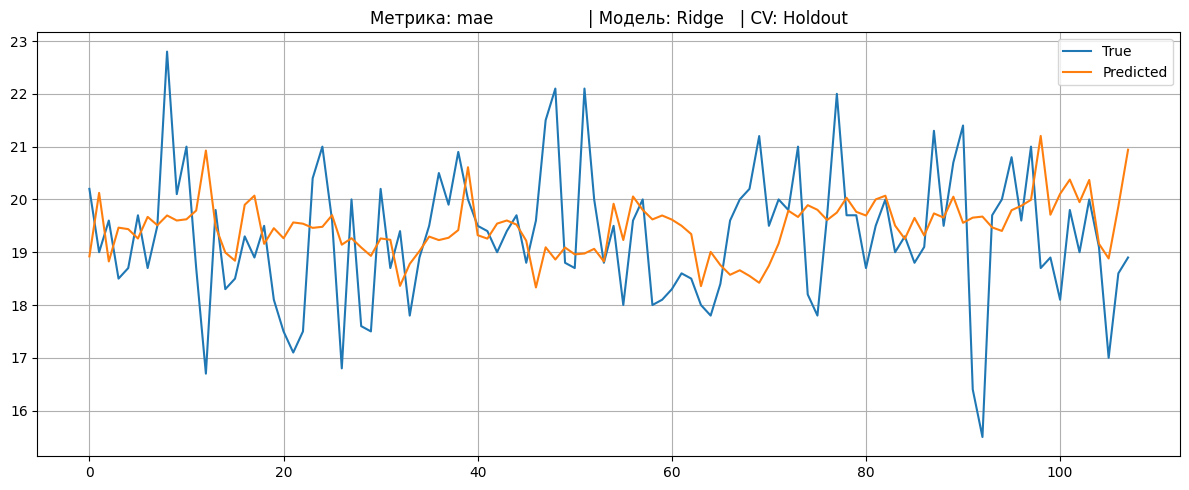

mse                   : RandomForest    | Holdout         | mse=1.7883


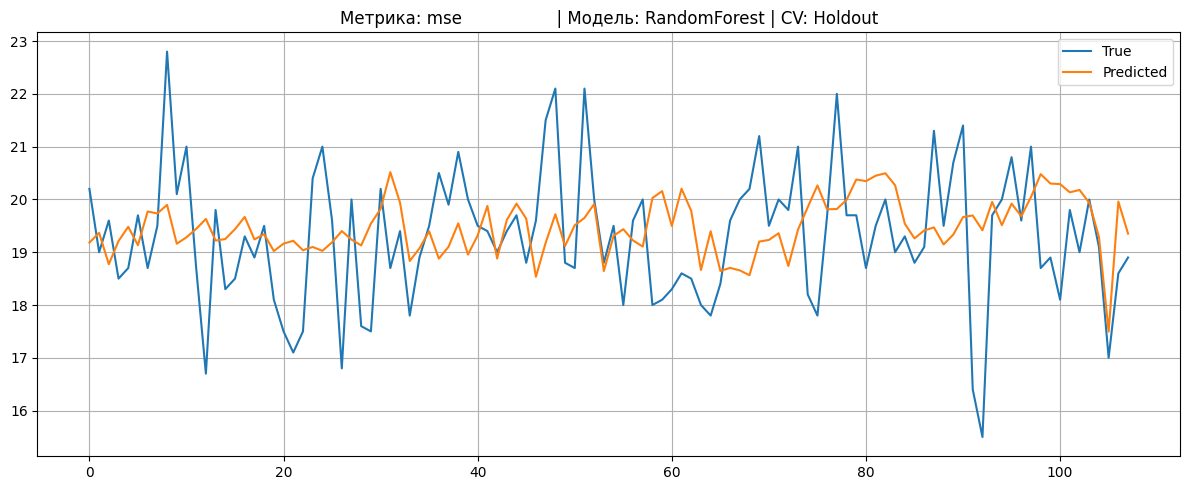

mae_baseline          : Ridge           | Holdout         | mae_baseline=0.9657


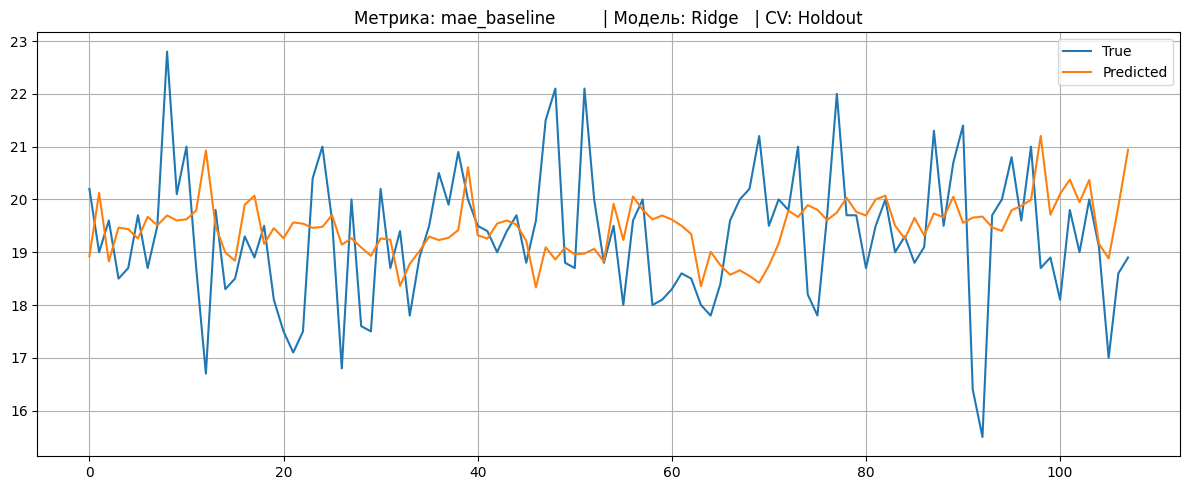

mae_baseline_shift    : Ridge           | Holdout         | mae_baseline_shift=1.1935


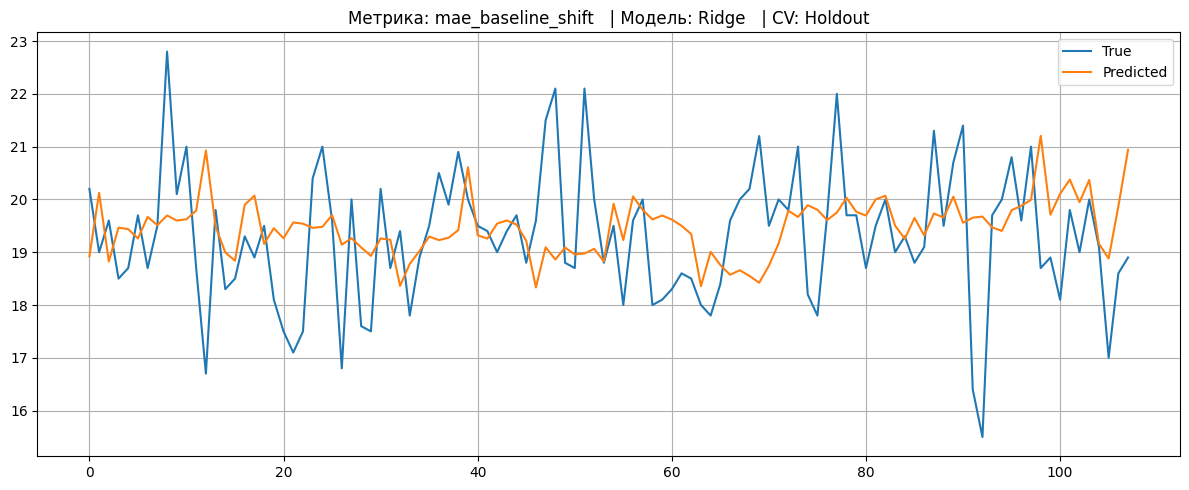

same_direction_ratio  : CatBoost        | KFold           | same_direction_ratio=0.5918


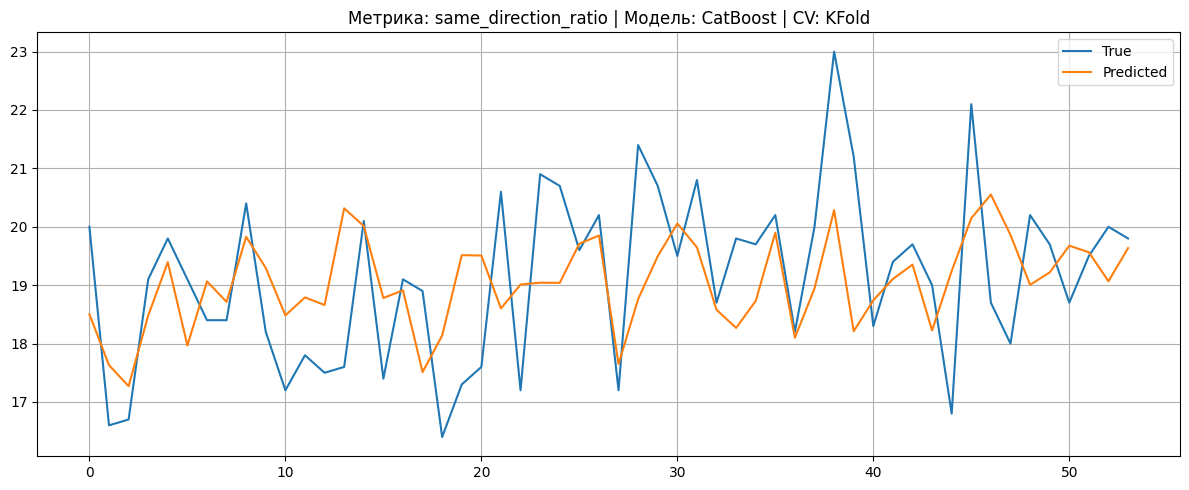

In [ ]:
metrics = ['mae', 'mse', 'mae_baseline',
           'mae_baseline_shift', 'same_direction_ratio']

res_df = (pd.DataFrame(results)
          .round(4)
          .sort_values('mae')
          .reset_index(drop=True))

for m in metrics:
    idx = res_df[m].idxmax(
    ) if m == 'same_direction_ratio' else res_df[m].idxmin()
    row = res_df.loc[idx]
    print(f'{m:<22}: {row.model:<15} | {row.cv:<15} | {m}={row[m]:.4f}')
    
    import matplotlib.pyplot as plt

    best_idx = res_df['mae'].idxmin()
    best_row = res_df.loc[best_idx]
    best_model = models[best_row['model']]
    best_cv = cv_dict[best_row['cv']]

for m in metrics:
    # Выбор наилучшей модели по метрике
    idx = res_df[m].idxmax(
    ) if m == 'same_direction_ratio' else res_df[m].idxmin()
    row = res_df.loc[idx]

    print(f'{m:<22}: {row.model:<15} | {row.cv:<15} | {m}={row[m]:.4f}')

    model = models[row['model']]
    cv = cv_dict[row['cv']]

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        plt.figure(figsize=(12, 5))
        plt.plot(y_test.values, label='True')
        plt.plot(y_pred, label='Predicted')
        plt.title(f"Метрика: {m:<20} | Модель: {row['model']:<7} | CV: {row['cv']}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        break

In [15]:
display(res_df)

,model,cv,mae,mse,mae_baseline,mae_baseline_shift,same_direction_ratio
0,Ridge,Holdout,1.0585,1.9116,0.9657,1.1935,0.4766
1,LinearRegression,Holdout,1.0624,1.9266,0.9657,1.1935,0.4766
2,RandomForest,Holdout,1.0725,1.7883,0.9657,1.1935,0.5234
3,CatBoost,Holdout,1.1266,1.9358,0.9657,1.1935,0.4673
4,GradientBoosting,Holdout,1.1337,2.1016,0.9657,1.1935,0.4579
5,RandomForest,KFold,1.1439,1.9985,1.2316,1.6344,0.5426
6,CatBoost,KFold,1.1463,2.0512,1.2316,1.6344,0.5918
7,XGBoost,Holdout,1.1706,2.0579,0.9657,1.1935,0.5701
8,Ridge,KFold,1.1742,2.1065,1.2316,1.6344,0.5727
9,LinearRegression,KFold,1.1744,2.1077,1.2316,1.6344,0.5746
